# Time Series Analysis with Airline Passenger Forecasting

### Import the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

from pmdarima.arima import ADFTest, auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

### Load the Dataset

In [2]:
df = pd.read_csv('airpassengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Set the date column to a DateTime field (if it isn't already), then set that as the index

In [3]:
print(df.dtypes)

Month         object
Passengers     int64
dtype: object


In [4]:
df['Month'] = pd.to_datetime(df['Month'])
print(df.dtypes)

Month         datetime64[ns]
Passengers             int64
dtype: object


In [5]:
df.set_index('Month', inplace = True)
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


### Add Month and Year columns to make visualizations easier

In [6]:
df['year'] = [d.year for d in df.index]
df['month'] = [d.month for d in df.index]
df

,Passengers,year,month
Month,,,
1949-01-01,112,1949,1
1949-02-01,118,1949,2
1949-03-01,132,1949,3
1949-04-01,129,1949,4
1949-05-01,121,1949,5
...,...,...,...
1960-08-01,606,1960,8
1960-09-01,508,1960,9
1960-10-01,461,1960,10


### Boxplot visualization shows the upward trend, year after year

<AxesSubplot:xlabel='year', ylabel='Passengers'>

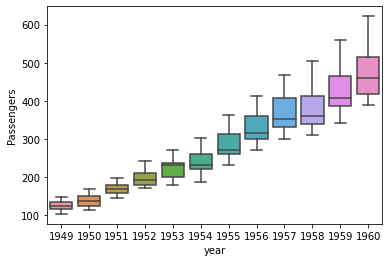

In [7]:
sns.boxplot(x = 'year', y = 'Passengers', data = df)

### Boxplot visualization shows the seasonal trend, month after month

<AxesSubplot:xlabel='month', ylabel='Passengers'>

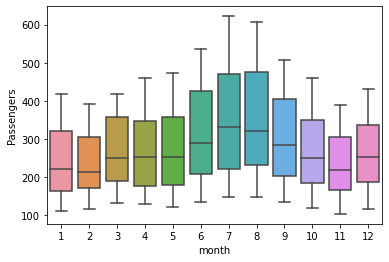

In [8]:
sns.boxplot(x = 'month', y = 'Passengers', data = df)

### Decomposing the series to show original data, upward trend, seasonal variation, and residual

In [9]:
decomposed = seasonal_decompose(df['Passengers'], model = 'additive')

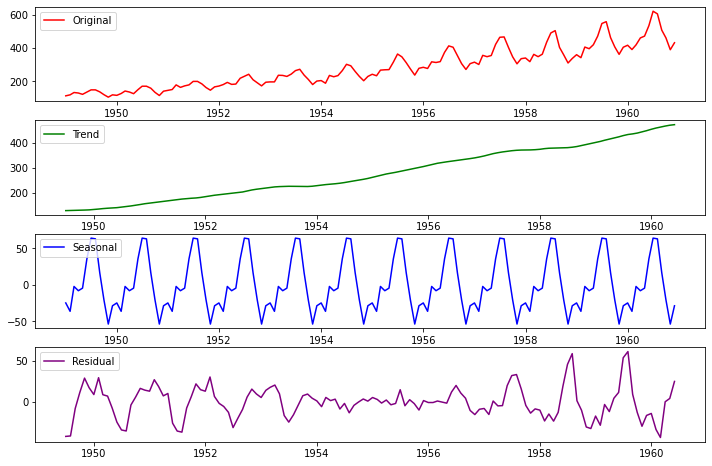

In [10]:
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

plt.figure(figsize = (12, 8))
plt.subplot(411)
plt.plot(df['Passengers'], label = 'Original', color = 'red')
plt.legend(loc = 'upper left')
plt.subplot(412)
plt.plot(trend, label = 'Trend', color = 'green')
plt.legend(loc = 'upper left')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal', color = 'blue')
plt.legend(loc = 'upper left')
plt.subplot(414)
plt.plot(residual, label = 'Residual', color = 'purple')
plt.legend(loc = 'upper left')
plt.show()

# Building the ARIMA Model

###### The first step is to determine which model (and set of parameters) is the best to use. The simplest way is to use auto_arima, which runs through all the model & parameter scenarios for you.

In [11]:
arima_model = auto_arima(df['Passengers'], start_p = 1, d = 1, start_q = 1,
                        max_p = 5, max_q = 5, max_d = 5, m = 12,
                        start_P = 0, D = 1, start_Q = 0, max_P = 5, max_D = 5, 
                        max_Q = 5, seasonal = True, trace = True,
                        error_action = 'ignore', suppress_warnings = True,
                        stepwise = True, n_fits = 50)
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.25 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.56 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.22 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.27 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.14 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.29 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.39 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.25 sec
 ARIMA(0,1,1)(1,1,0)[12]     

###### The result is the SARIMA (Seasonal ARIMA) model, with parameters (0, 1, 1), (2, 1, 0), [12]

###### Now plot the diagnostics. The residual errors (upper left) fluctuate around a mean of zero and have a uniform variance. The density plot (upper right) suggest a normal distribution with a mean of zero. The dots in the scatterplot (lower left) align with the red line, whereas any significant deviations would imply a skewness in the distribution. The correlogram (lower right) shows the residual errors are not correlated (any autocorrelation would imply a patter in the residual errors not explained in the model).

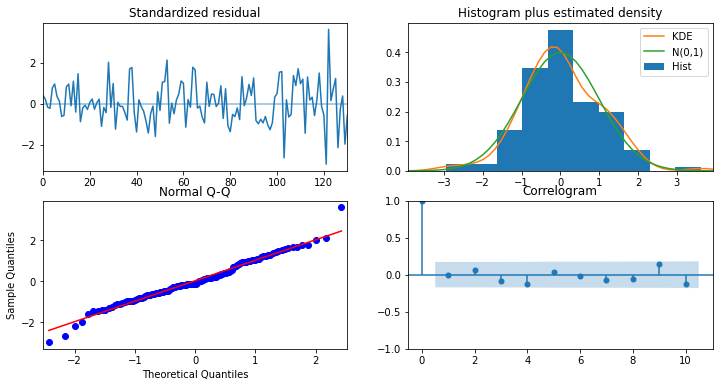

In [12]:
arima_model.plot_diagnostics(figsize = (12, 6))
plt.show()

### Split into train and test

In [13]:
size = int(len(df) * 0.66)
x_train, x_test = df['Passengers'][0:size], df['Passengers'][size:len(df)]

In [14]:
model = SARIMAX(x_train, order = (0, 1, 1), seasonal_order = (2, 1, 0, 12))
result = model.fit()
result.summary()

C:\Users\lawto\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\lawto\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Passengers   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -301.702
Date:                             Sat, 12 Feb 2022   AIC                            611.404
Time:                                     13:13:41   BIC                            621.031
Sample:                                 01-01-1949   HQIC                           615.270
                                      - 11-01-1956                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2597      0.104     -2.503      0.012      -0.463      -0.056
ar.S.L12      -0.2033      0.111     -1.829      0.067      -0.421       0.015
ar.S.L24       0.0548      0.126      0.435      0.663      -0.192       0.302
sigma2        91.1088     15.146      6.015      0.000      61.423     120.795
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.30
Prob(Q):                              0.99   Prob(JB):                         0.32
Heteroskedasticity (H):               1.75   Skew:                             0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Training Data

In [15]:
start_index = 0
end_index = len(x_train) - 1
train_prediction = result.predict(start_index, end_index)
train_prediction.head()

1949-01-01      0.000000
1949-02-01    111.998607
1949-03-01    117.999851
1949-04-01    131.999652
1949-05-01    129.000075
Freq: MS, Name: predicted_mean, dtype: float64

### Testing Data

In [16]:
start_index = len(x_train)
end_index = len(df) - 1
test_prediction = result.predict(start_index, end_index)
test_prediction.head()

1956-12-01    310.429023
1957-01-01    318.400465
1957-02-01    311.377580
1957-03-01    349.444991
1957-04-01    347.213116
Freq: MS, Name: predicted_mean, dtype: float64

### Plot Predicted versus Actual

<AxesSubplot:xlabel='Month'>

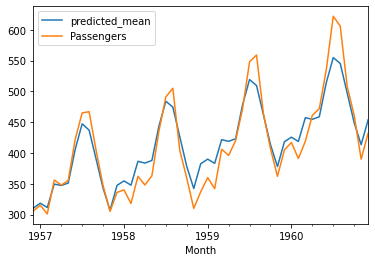

In [17]:
test_prediction.plot(legend = True)
x_test.plot(legend = True)

In [18]:
train_score = math.sqrt(mean_squared_error(x_train, train_prediction))
print('Train Score = %.2f RMSE' % train_score)
test_score = math.sqrt(mean_squared_error(x_test, test_prediction))
print('Test Score = %.2f RMSE ' % test_score)

Train Score = 16.24 RMSE
Test Score = 24.81 RMSE 


### Forecasting

In [19]:
forecast = result.predict(start = len(df), end = (len(df) - 1) + 3 * 12, typ = 'levels').rename('Forecast')

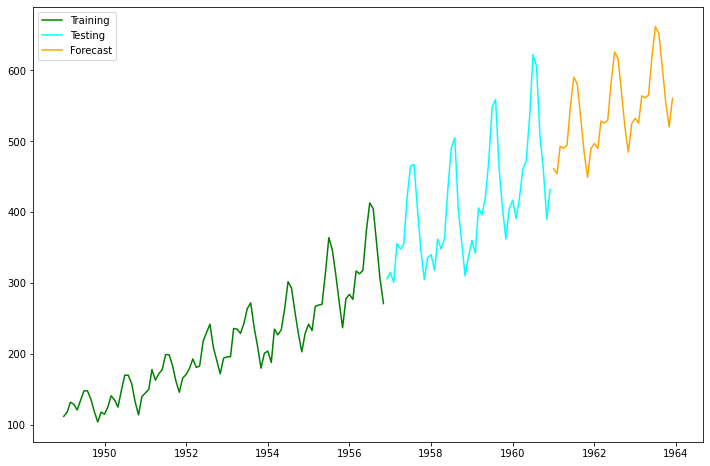

In [20]:
plt.figure(figsize = (12, 8))
plt.plot(x_train, label = 'Training', color = 'green')
plt.plot(x_test, label = 'Testing', color = 'cyan')
plt.plot(forecast, label = 'Forecast', color = 'orange')
plt.legend(loc = 'upper left')
plt.show()

# Building the Neural Network Model

### Reload the dataset, but skip the date column

In [21]:
df = pd.read_csv('airpassengers.csv', usecols = [1])
df.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


### Change to a numpy array, and convert to float type

In [22]:
dataset = df.values
dataset = dataset.astype('float32')

### Scale everything so all data points fall between 0 and 1

In [23]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

### Split into training and testing

In [24]:
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [25]:
def to_sequences(dataset, seq_size = 1):
    x = []
    y = []
    for i in range(len(dataset) - seq_size - 1):
        window = dataset[i:(i + seq_size), 0]
        x.append(window)
        y.append(dataset[i + seq_size, 0])
    return np.array(x), np.array(y)

###### Create a moving window of 5 (or whatever) data points in order to predict the 6th

In [35]:
# The number of time units to look back
# larger sequence sizes (looking further back) may improve forecasting
seq_size = 8
trainx, trainy = to_sequences(train, seq_size)
testx, testy = to_sequences(test, seq_size)

### Define the neural network model

In [36]:
model = Sequential()
model.add(Dense(64, input_dim = seq_size, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
model.fit(trainx, trainy, validation_data = (testx, testy), verbose = 2, epochs = 100)

Epoch 1/100
3/3 - 0s - loss: 0.0120 - acc: 0.0116 - val_loss: 0.0280 - val_acc: 0.0250
Epoch 2/100
3/3 - 0s - loss: 0.0054 - acc: 0.0116 - val_loss: 0.0295 - val_acc: 0.0250
Epoch 3/100
3/3 - 0s - loss: 0.0062 - acc: 0.0116 - val_loss: 0.0256 - val_acc: 0.0250
Epoch 4/100
3/3 - 0s - loss: 0.0048 - acc: 0.0116 - val_loss: 0.0177 - val_acc: 0.0250
Epoch 5/100
3/3 - 0s - loss: 0.0036 - acc: 0.0116 - val_loss: 0.0191 - val_acc: 0.0250
Epoch 6/100
3/3 - 0s - loss: 0.0038 - acc: 0.0116 - val_loss: 0.0196 - val_acc: 0.0250
Epoch 7/100
3/3 - 0s - loss: 0.0037 - acc: 0.0116 - val_loss: 0.0157 - val_acc: 0.0250
Epoch 8/100
3/3 - 0s - loss: 0.0030 - acc: 0.0116 - val_loss: 0.0135 - val_acc: 0.0250
Epoch 9/100
3/3 - 0s - loss: 0.0029 - acc: 0.0116 - val_loss: 0.0135 - val_acc: 0.0250
Epoch 10/100
3/3 - 0s - loss: 0.0029 - acc: 0.0116 - val_loss: 0.0125 - val_acc: 0.0250
Epoch 11/100
3/3 - 0s - loss: 0.0026 - acc: 0.0116 - val_loss: 0.0121 - val_acc: 0.0250
Epoch 12/100
3/3 - 0s - loss: 0.0025 - ac

Epoch 93/100
3/3 - 0s - loss: 7.3294e-04 - acc: 0.0116 - val_loss: 0.0042 - val_acc: 0.0250
Epoch 94/100
3/3 - 0s - loss: 7.6752e-04 - acc: 0.0116 - val_loss: 0.0036 - val_acc: 0.0250
Epoch 95/100
3/3 - 0s - loss: 7.4837e-04 - acc: 0.0116 - val_loss: 0.0036 - val_acc: 0.0250
Epoch 96/100
3/3 - 0s - loss: 7.1480e-04 - acc: 0.0116 - val_loss: 0.0038 - val_acc: 0.0250
Epoch 97/100
3/3 - 0s - loss: 7.3862e-04 - acc: 0.0116 - val_loss: 0.0036 - val_acc: 0.0250
Epoch 98/100
3/3 - 0s - loss: 7.3288e-04 - acc: 0.0116 - val_loss: 0.0037 - val_acc: 0.0250
Epoch 99/100
3/3 - 0s - loss: 7.7470e-04 - acc: 0.0116 - val_loss: 0.0038 - val_acc: 0.0250
Epoch 100/100
3/3 - 0s - loss: 7.0273e-04 - acc: 0.0116 - val_loss: 0.0035 - val_acc: 0.0250


In [38]:
trainpredict = model.predict(trainx)
testpredict = model.predict(testx)

In [39]:
trainpredict = scaler.inverse_transform(trainpredict)
trainy_inverse = scaler.inverse_transform([trainy])
testpredict = scaler.inverse_transform(testpredict)
testy_inverse = scaler.inverse_transform([testy])

### Print the accuracy scores

In [40]:
trainscore = math.sqrt(mean_squared_error(trainy_inverse[0], trainpredict[:, 0]))
print('Train Score = %.2f RMSE' % trainscore)
testscore = math.sqrt(mean_squared_error(testy_inverse[0], testpredict[:, 0]))
print('Test Score = %.2f RMSE' % testscore)

Train Score = 13.70 RMSE
Test Score = 30.78 RMSE


### Plot the results

In [ ]:
trainpredictplot = np.empty_like(dataset)
trainpredictplot[:, :] = np.nan
trainpredictplot[seq_size:len(trainpredict) + seq_size, :] = trainpredict

In [42]:
testpredictplot = np.empty_like(dataset)
testpredictplot[:, :] = np.nan
testpredictplot[len(trainpredict) + (seq_size*2) + 1:len(dataset) - 1, :] = testpredict

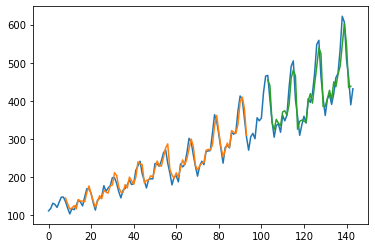

In [43]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainpredictplot)
plt.plot(testpredictplot)
plt.show()